ФИО: Притугин Михаил Алексеевич

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.autograd import Variable, grad
from utils import create_dataloader
from torch.utils.data import Dataset, DataLoader

import time

%matplotlib inline

In [2]:
def get_noise(bs=16, noise_size=50):
    return Variable(torch.FloatTensor(bs, noise_size).normal_(0, 1), requires_grad=False)

In [3]:
class DataAcc:
    def __init__(self, dataloader):
        self.dl = dataloader
        self.it = iter(self.dl)
        
    def reset(self):
        self.it = iter(self.dl)
    
    def get_next(self):
        res = None
        try:
            res = next(self.it)
        except:
            print('DataAcc reinit')
            self.reset()
            res = next(self.it)
        return res

# data_acc = DataAcc(dataloader)

### Creating config object (argparse workaround)

In [4]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 50
config.print_freq = 100

### Create dataloder

In [5]:
dataloader = create_dataloader(config)

0it [00:00, ?it/s]

 99%|█████████▊| 9773056/9912422 [00:16<00:00, 1927243.65it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz



0it [00:00, ?it/s]


 57%|█████▋    | 16384/28881 [00:00<00:00, 121975.40it/s]
32768it [00:00, 78962.13it/s]                            
0it [00:00, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz



 89%|████████▉ | 1466368/1648877 [00:11<00:02, 67647.49it/s]
9920512it [00:30, 1927243.65it/s]                             A
 99%|█████████▉| 1638400/1648877 [00:12<00:00, 115556.52it/s]

0it [00:00, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz




  0%|          | 0/4542 [00:00<?, ?it/s]

8192it [00:00, 17936.67it/s]            

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!



1654784it [00:32, 115556.52it/s]                             

In [6]:
len(dataloader)

3750

### Create generator and discriminator

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())
        
    def forward(self, x):
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1), 
            nn.Sigmoid())
    def forward(self, x):
        return self.model(x)

In [8]:
generator = Generator().cpu()
discriminator = Discriminator().cpu()

### Create optimizers and loss

In [9]:
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

### Create necessary variables

In [10]:
input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

### Задание

1) Имплементируйте GAN из статьи

2) Попробуйте LSGAN https://arxiv.org/pdf/1611.04076v2.pdf

3) Попробуйте оба GAN на CelebA http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

4) Напишите отчет что попробовали, какие результаты получили, как вам кажется надо обучать GAN, чтобы добиться сходимости?

Обязательны графики.

### Main loop

#### GAN on MNIST

In [ ]:
criterion = nn.BCELoss()
for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        #######
        discriminator.zero_grad()
        
        # real
        images = Variable(images, requires_grad=False).view(-1, 784).cpu()
        loss = criterion(discriminator(images), Variable(torch.ones(config.batch_size, 1)).cpu())
        loss.backward()
        errD_x = loss.data.item()
        
        # fake
        fake_images = generator(get_noise().cpu()).detach()
        loss = criterion(discriminator(fake_images), Variable(torch.zeros(config.batch_size, 1)).cpu())
        loss.backward()
        errD_z = loss.data.item()
        
        optim_D.step()
        
        ####### 
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        
        fake_images = generator(get_noise().cpu())
        loss = criterion(discriminator(fake_images), Variable(torch.ones(config.batch_size, 1)).cpu())
        loss.backward()
        errG = loss.data.item()
        
        optim_G.step()
        
        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1, 
                                                                                            errD_x,
                                                                                            errD_z, 
                                                                                            errG))
    

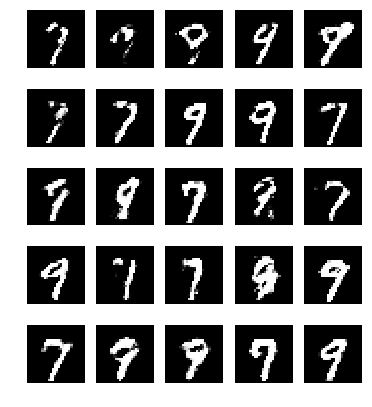

In [15]:
X = generator(get_noise(25).cpu()).data.cpu().numpy()

plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

#### LSGAN on MNIST

In [20]:
generator = Generator().cpu()
discriminator = Discriminator().cpu()

optim_G = optim.Adam(params=generator.parameters(), lr=0.00004)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.00003)

In [ ]:
criterion = nn.MSELoss()
for iteration in range(3000):
    errD_x = 0
    errD_z = 0
    errG = 0
    for _ in range(3):
        ####### 
        # Discriminator stage: minimize (D(x) - 1)^2 + (D(G(z)))^2
        #######
        discriminator.zero_grad()
        images, _ = data_acc.get_next()
        # real
        images = Variable(images, requires_grad=False).view(-1, 784).cpu()
        loss = criterion(discriminator(images), Variable(torch.ones(config.batch_size, 1)).cpu())
        loss.backward()
        errD_x = loss.data.item()
        
        # fake
        fake_images = generator(get_noise().cpu()).detach()
        loss = criterion(discriminator(fake_images), Variable(torch.zeros(config.batch_size, 1)).cpu())
        loss.backward()
        errD_z = loss.data.item()
        
        optim_D.step()
        
    for _ in range(1):
        ####### 
        # Generator stage: minmize (D(G(x) - 1)^2
        #######
        generator.zero_grad()
        
        fake_images = generator(get_noise().cpu())
        loss = criterion(discriminator(fake_images), Variable(torch.ones(config.batch_size, 1)).cpu())
        loss.backward()
        errG = loss.data.item()
        
        optim_G.step()
        
    if (iteration+1) % 100 == 0:
        print('Iter:{} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(iteration+1,
                                                                                    errD_x,
                                                                                    errD_z, 
                                                                                    errG))

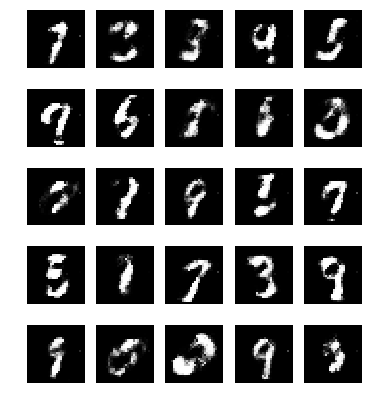

In [46]:
X = generator(get_noise(25).cpu()).data.cpu().numpy()

plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')